In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import NormalDistPredictor
from models.rnn_model import BaseLSTMModel, RNNRouter

# from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.PPO_RNN import PPORNNDiscrete
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callbacks import tqdm_callback

In [5]:
actor_lr = 1e-4
critic_lr = 1e-3

hidden_size = 128

discount = 0.99

clip_ratio = 0.95
ppo_steps = 4

num_envs = 8

iters = 1000

max_episode_steps = 500

env_name = "CartPole-v1"

In [6]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape
action_num = env.action_space(env_params).n
action_size = 1

In [7]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    obs_dummy = jnp.ones([1, 1, *obs_size])
    done_dummy = jnp.ones([1, 1, 1])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 2), RNNRouter(nn.Dense(features = action_num))])
    actor_params = actor_model.init(actor_init_key, obs_dummy, done_dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 2), RNNRouter(nn.Dense(features = 1))])
    critic_params = critic_model.init(critic_init_key, obs_dummy, done_dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = PPORNNDiscrete(gae_estimator(discount, 0.95), clip_ratio, ppo_steps)
    
    logger = jnp.zeros((iters, 1))

    rnn_carry_initializer = lambda k: nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(k, (num_envs, hidden_size))

    fori_body = build_trainer(agent, env, env_params, num_envs, obs_size, action_size, max_episode_steps, tqdm_callback(iters), use_rnn_agent = True, rnn_carry_initializer = rnn_carry_initializer)
    
    carry = (actor, critic, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 1000/1000 [08:16<00:00,  2.61it/s, Reward=500.0, Total reward=4000.0, actions=[ 0.  1. -1. -1.], aux=0.36438155]   

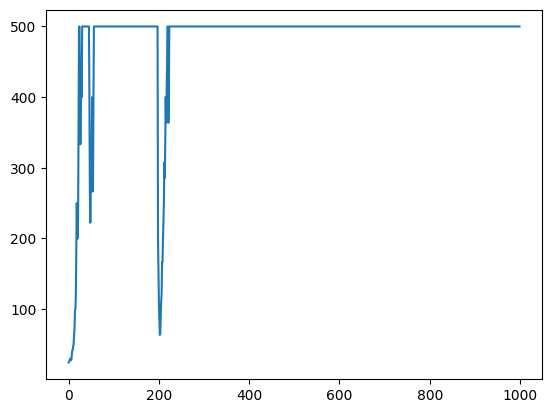

In [8]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

In [9]:
actor = carry[0]

  0%|          | 0/500 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.


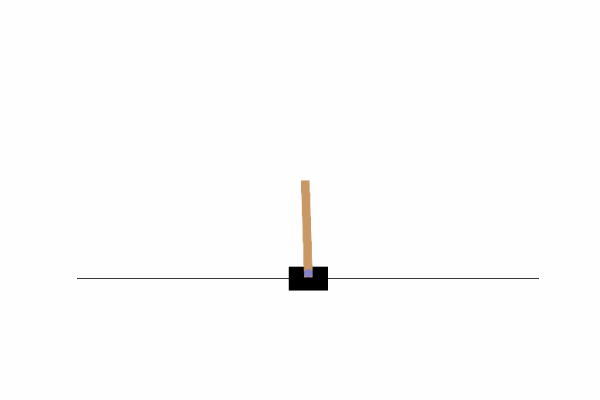

In [10]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

import numpy as np

actor = carry[0]

gym_env = gym.make(env_name, render_mode="rgb_array")

c = nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(key, (1, hidden_size))
done = jnp.ones((1, 1, 1))

obs, _ = gym_env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(gym_env.render())
    c, action = agent.suggest_action(jnp.expand_dims(obs, (0, 1)), c, jnp.reshape(done, (1, 1)), actor)
    action = action.item()
    
    obs, _, done, _, _ = gym_env.step(action)
    if done:
        break
        
gym_env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())